In [ ]:
pip install botorch

In [2]:
import pandas as pd
import torch

#import random
#random.seed(0)
#import numpy as np
#np.random.seed(0)

train_data = pd.read_excel('data_sample_multiple_components_withoutAverage_XYLOSE_9objs_iter00.xlsx')
#print(train_data)
train_x = train_data.iloc[:,[0,1]].values
#print(train_X)
train_x = torch.tensor(train_x, dtype=torch.float32)
print(train_x)

train_obj = train_data.iloc[:,2:].values
#print(train_Y)
train_obj = torch.tensor(train_obj, dtype=torch.float32)
print(train_obj)

tensor([[0.0050, 0.5000],
        [0.0050, 0.5000],
        [0.0050, 0.5000],
        [0.0050, 1.0000],
        [0.0050, 1.0000],
        [0.0050, 1.0000],
        [0.0050, 2.0000],
        [0.0050, 2.0000],
        [0.0050, 2.0000],
        [0.0406, 0.5000],
        [0.0406, 0.5000],
        [0.0406, 0.5000],
        [0.0406, 1.0000],
        [0.0406, 1.0000],
        [0.0406, 1.0000],
        [0.0406, 2.0000],
        [0.0406, 2.0000],
        [0.0406, 2.0000]])
tensor([[ 0.1151,  0.0591,  0.0179,  0.1398,  0.0145,  0.1592,  0.0000,  0.0449,
         -0.4976],
        [ 0.1204,  0.0640,  0.0071,  0.0992,  0.0158,  0.1706,  0.0000,  0.0681,
         -0.5348],
        [ 0.1208,  0.0784,  0.0150,  0.1011,  0.0197,  0.2304,  0.0000,  0.0672,
         -0.5016],
        [ 0.1024,  0.0539,  0.0177,  0.1356,  0.0156,  0.1934,  0.0000,  0.0000,
         -0.7619],
        [ 0.1322,  0.0667,  0.0117,  0.1610,  0.0230,  0.2715,  0.0000,  0.0000,
         -0.8775],
        [ 0.0982,  0.0602,  0.0

In [3]:
from botorch import fit_gpytorch_model
from botorch.models.gp_regression import FixedNoiseGP
from botorch.models.transforms.outcome import Standardize
from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.optim.optimize import optimize_acqf

torch.manual_seed(0)

NOISE_SE = torch.tensor([1,1,1,1,1,1,1,1,1])
#print(NOISE_SE)

# define models for objective and constraint
models = []
for i in range(train_obj.shape[-1]):
    train_y = train_obj[..., i:i+1]
    train_yvar = torch.full_like(train_y, NOISE_SE[i] ** 2)
    models.append(FixedNoiseGP(train_x, train_y, train_yvar, outcome_transform=Standardize(m=1)))
model = ModelListGP(*models)
mll = SumMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

BATCH_SIZE = 10
NUM_RESTARTS = 2
RAW_SAMPLES = 4
MC_SAMPLES = 16

standard_bounds = torch.tensor([[0.001, 0.1],[0.05, 3]])
#print(standard_bounds)
ref_point=torch.tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0])

with torch.no_grad():
  #pred = model.posterior(normalize(train_x, standard_bounds)).mean
  pred = model.posterior(train_x).mean
partitioning = FastNondominatedPartitioning(ref_point, Y=pred)
sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
acq_func = qExpectedHypervolumeImprovement(model,ref_point,partitioning,sampler)

candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        #options={"batch_limit": 5, "maxiter": 200},
        sequential=True)
#candidates =  unnormalize(candidates.detach(), bounds=standard_bounds)
print(candidates)

/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/lazy_tensor.py:1810: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


tensor([[4.1770e-02, 1.5790e-01],
        [1.3619e-02, 2.5995e+00],
        [1.9970e-02, 2.2111e-01],
        [4.4772e-02, 2.0989e+00],
        [3.9377e-02, 1.7199e+00],
        [1.2088e-03, 3.8620e-01],
        [4.0980e-03, 6.6677e-01],
        [5.1903e-03, 2.7432e+00],
        [3.3898e-02, 2.4039e+00],
        [2.4758e-02, 2.5757e-01]])


In [4]:
selected_candidates_idx = [5,1,9,0,3]
selected_candidates = candidates[selected_candidates_idx]
print(selected_candidates)
pred = model.posterior(selected_candidates).mean.squeeze().detach().numpy()
print(pred)

ground_truth_data = pd.read_excel('data_sample_multiple_components_withoutAverage_XYLOSE_9objs_iter01.xlsx')
gt_x = ground_truth_data.iloc[-5:,[0,1]].values
gt_x = torch.tensor(gt_x, dtype=torch.float32)
print(gt_x)

gt_y = ground_truth_data.iloc[-5:,2:].values
gt_y = torch.tensor(gt_y, dtype=torch.float32)
print(gt_y)

tensor([[1.2088e-03, 3.8620e-01],
        [1.3619e-02, 2.5995e+00],
        [2.4758e-02, 2.5757e-01],
        [4.1770e-02, 1.5790e-01],
        [4.4772e-02, 2.0989e+00]])
[[ 0.10062254  0.05864052  0.01210833  0.12456533  0.01590535  0.19137996
   0.04283233  0.01035036 -0.7154851 ]
 [ 0.09949002  0.05834174  0.01210758  0.12491009  0.01590623  0.19274828
   0.04349155  0.00996444 -0.77307737]
 [ 0.10039482  0.05858151  0.01210818  0.12463284  0.01590552  0.19163907
   0.04297281  0.01027166 -0.72696686]
 [ 0.10021842  0.0585317   0.01210807  0.12469376  0.01590566  0.19189961
   0.04308145  0.01020252 -0.7370997 ]
 [ 0.09848706  0.05814686  0.01210682  0.12506032  0.015907    0.19292289
   0.04397837  0.00980681 -0.79893154]]
tensor([[1.2088e-03, 3.8620e-01],
        [1.3619e-02, 2.5995e+00],
        [2.4758e-02, 2.5750e-01],
        [4.1170e-02, 1.5790e-01],
        [4.4772e-02, 2.0989e+00]])
tensor([[ 0.0775,  0.0430,  0.0218,  0.0000,  0.0208,  0.1867,  0.0000,  0.0252,
         -0

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
rmse = mean_squared_error(gt_y, pred, multioutput='raw_values',squared=False)
print(rmse)
mae = mean_absolute_error(gt_y, pred, multioutput='raw_values')
print(mae)

[0.02934417 0.04291347 0.00640946 0.06421259 0.00878954 0.02259344
 0.06953099 0.01430563 0.45225087]
[0.02352292 0.03162528 0.00559806 0.05029143 0.00843321 0.01991939
 0.04664189 0.01389415 0.41869694]


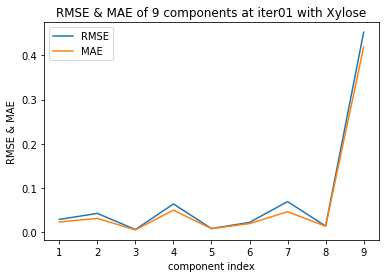

In [6]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([1,2,3,4,5,6,7,8,9])
plt.plot(x, rmse, label='RMSE')
plt.plot(x, mae, label='MAE')
plt.title("RMSE & MAE of 9 components at iter01 with Xylose")
plt.xlabel("component index")
plt.ylabel("RMSE & MAE")
plt.legend()
plt.show()